In [4]:
import sys
sys.path.append('/home/kotobiam/hida_project/')

In [5]:
import os.path as osp
import os
import random

from utils.broadening import spectrum, group_broadening
from attribution_gnn1.QM9_SpecData import QM9_SpecData

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', palette='muted', font_scale=1.5)

from pylab import rc, rcParams
rc('text', usetex=False)
rc('axes', linewidth=2) 
rc('font', weight='normal')

params = {'legend.fontsize': 15,
          'figure.figsize': (10, 8),}
rcParams.update(params)

# Importing nexafs spectra of 20k qm9 structures

In [3]:
data_spectra = np.load(osp.join('/p/home/jusers/kotobi2/juwels/data_qm9/all_npz_files/', 
                                'qm9_spectra_50k.npz'))

In [4]:
data_spectra_test = np.load(osp.join('/p/home/jusers/kotobi2/juwels/data_qm9/all_npz_files/', 
                                'qm9_spectra_test.npz'))

In [5]:
for key in data_spectra:
    print(key)

#spectra_dat = torch.tensor(data_spectra['spec_dat'])
#spectra_dat = torch.stack(torch.split(spectra_dat, 500))

#split spectra with different shape than (500, 2)
spectra_stk = torch.tensor(data_spectra['spec_stk']) 
spectra_stk_test = torch.tensor(data_spectra_test['spec_stk'])

shape_lst = [312, 264, 216, 360, 312, 352, 440]

spectra1_stk = torch.split(spectra_stk[:2256,], shape_lst)
spectra2_stk = torch.stack(torch.split(spectra_stk[2256:,], 500))
spectra3_stk = torch.stack(torch.split(spectra_stk_test[:,], 500))

spec_stk
id


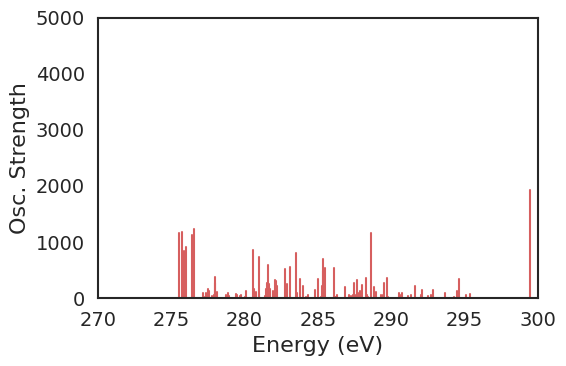

In [6]:
energies = spectra2_stk[100][:, 0]
osc = spectra2_stk[100][:, 1]

fig,ax=plt.subplots(figsize=(6,4))

for energy,osc_strength in zip(energies,osc):
    ax.plot((energy,energy),(0,osc_strength),c="r")
    
ax.set_xlabel("Energy (eV)",fontsize=16)
ax.xaxis.set_tick_params(labelsize=14,width=1.5)
ax.yaxis.set_tick_params(labelsize=14,width=1.5)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.set_xlim(270,300)
ax.set_ylim(0,5000)
ax.set_ylabel("Osc. Strength",fontsize=16)
plt.tight_layout()

In [7]:
#testing the spectrum function
x = torch.linspace(270, 300, 100)
sigma = torch.tensor(0.8)
gE=spectrum(energies,osc,sigma,x)

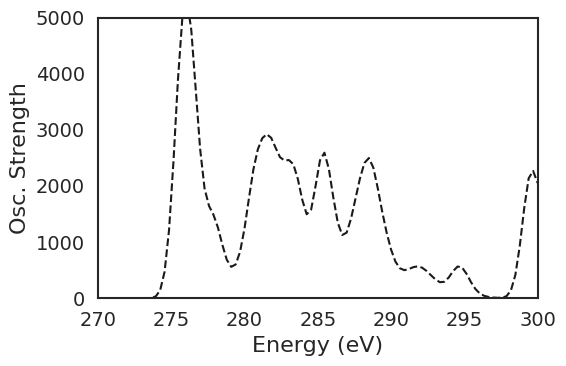

In [8]:
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(x,gE,"--k")
#for energy,osc_strength in zip(energies,osc):
 #   ax.plot((energy,energy),(0,osc_strength),c="r")
ax.set_xlabel("Energy (eV)",fontsize=16)
ax.xaxis.set_tick_params(labelsize=14,width=1.5)
ax.yaxis.set_tick_params(labelsize=14,width=1.5)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.set_xlim(270,300)
ax.set_ylim(0,5000)
ax.set_ylabel("Osc. Strength",fontsize=16)
plt.tight_layout()

# Broadening the spectra with fixed energy range

In [9]:
energies = torch.linspace(270, 300, 100)
sigma=torch.tensor(0.8)
broadened_spectra1 = group_broadening(spectra1_stk, sigma, energies)
broadened_spectra2 = group_broadening(spectra2_stk, sigma, energies)
broadened_spectra3 = group_broadening(spectra3_stk, sigma, energies)

100%|██████████| 6000/6000 [00:02<00:00, 2582.06it/s]


In [10]:
broadened_spectra_stk = broadened_spectra1 + broadened_spectra2 + broadened_spectra3

# QM9_SpecData dataset class

In [11]:
root = '/p/home/jusers/kotobi2/juwels/data_qm9/all_graph_data/qm9_spec_56k_0-8eV_bl.pt'
qm9_spec = QM9_SpecData(root=root,
             raw_dir='/p/home/jusers/kotobi2/juwels/data_qm9/raw/',
             spectra=broadened_spectra_stk)

if not osp.exists(root):
    torch.save(qm9_spec, root)

  0%|          | 0/133885 [00:00<?, ?it/s]/p/home/jusers/kotobi2/juwels/hida_project/attribution_gnn1/QM9_SpecData.py:183: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrum = torch.tensor(self.spectra[i], dtype=torch.float)
[08:09:04] Warning: molecule is tagged as 3D, but all Z coords are zero
 42%|████▏     | 56000/133885 [00:36<00:50, 1536.23it/s]


In [14]:
qm9_spec[2000]

Data(x=[18, 12], edge_index=[2, 36], edge_attr=[36, 5], pos=[18, 3], z=[18], spectrum=[100], idx=2000)

## shuffle the data

In [15]:
qm9_spec = [graph for graph in qm9_spec]
random.shuffle(qm9_spec)

In [16]:
# choosing the test data
qm9_spec_test = []
data_size = len(qm9_spec)
for i in range(6000):
    rand_idx = np.random.choice(data_size)
    qm9_spec_test.append(qm9_spec.pop(rand_idx))
    data_size -= 1

In [17]:
gdata_50k = '/p/home/jusers/kotobi2/juwels/data_qm9/all_graph_data/qm9_spec_50k_0-8eV_bl.pt'
if not osp.exists(gdata_50k):
    torch.save(qm9_spec, gdata_50k)

In [18]:
gdata_test = '/p/home/jusers/kotobi2/juwels/data_qm9/all_graph_data/qm9_spec_test_0-8eV_bl.pt'
if not osp.exists(gdata_test):
    torch.save(qm9_spec_test, gdata_test)

In [22]:
print(len(qm9_spec), len(qm9_spec_test))

50000 6000


## making 10, 20, 30, 40k datasets 

In [24]:
def pick_data(complete_data, pick_size, 
              pop_data=False):
    picked_qm9 = []
    picked_idxs = []
    data_size = len(complete_data)
    #for i in range(pick_size):
    while len(picked_idxs) < pick_size:
        rand_idx = np.random.choice(data_size) 
        if pop_data:
            picked_qm9.append(complete_data.pop(rand_idx))
            data_size -= 1
        else:
            if rand_idx in picked_idxs:
                continue
            picked_idxs.append(rand_idx)
            picked_qm9.append(complete_data[rand_idx])
        
    return picked_qm9

In [61]:
picked_data = pick_data(qm9_spec, pick_size=10000)

In [62]:
picked_data = [graph[0] for graph in picked_data]

In [63]:
len(picked_data)

10000

In [16]:
gdata = '/p/home/jusers/kotobi2/juwels/data_qm9/all_graph_data/qm9_spec_10k_0-8eV.pt'
if not osp.exists(gdata):
    torch.save(picked_data, gdata)

KeyboardInterrupt: 

# randomly choosing structures from test dataset

In [26]:
rand_struc_test = pick_data(qm9_spec_test, pick_size=50)

In [27]:
gdata = '/p/home/jusers/kotobi2/juwels/data_qm9/all_graph_data/qm9_spec_random50_0-8eV_bl.pt'
if not osp.exists(gdata):
    torch.save(rand_struc_test, gdata)